# Transfer Learning with EfficientNetB0

## 1. Imports and paths

In [1]:
import os
import sys
import time
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

from tensorflow.keras.applications import EfficientNetB0

# Ensure project root is on sys.path so `utils` can be imported
cwd = Path.cwd()
if cwd.name.lower() == "notebooks":
    project_root = cwd.parent
elif cwd.name.lower() == "cifar10_project":
    project_root = cwd
elif (cwd / "cifar10_project").is_dir():
    project_root = cwd / "cifar10_project"
else:
    project_root = None

if project_root is not None and str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from utils.ml_utils import (
    build_tf_dataset,
    evaluate_and_log_model,
    format_duration,
    predict_and_resolve_labels,
    compute_confusion_matrix,
    build_classification_report,
    plot_confusion_matrix_notebook01,
    plot_training_curves_notebook01,
)

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPU(s) detectada(s): {len(gpus)}")
else:
    print("Nenhuma GPU detectada. A correr em CPU.")

print("TF version:", tf.__version__)

2026-02-19 01:55:43.092719: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-19 01:55:43.121494: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-19 01:55:43.610218: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


GPU(s) detectada(s): 1
TF version: 2.16.1


2026-02-19 01:55:44.124556: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-19 01:55:44.154994: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-19 01:55:44.155180: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
PROJECT_ROOT = os.getcwd()
if os.path.basename(PROJECT_ROOT).lower() == 'notebooks':
    PROJECT_ROOT = os.path.dirname(PROJECT_ROOT)
elif os.path.basename(PROJECT_ROOT).lower() != 'cifar10_project':
    candidate = os.path.join(PROJECT_ROOT, 'cifar10_project')
    if os.path.isdir(candidate):
        PROJECT_ROOT = candidate

DATA_DIR = os.path.join(PROJECT_ROOT, 'data')
PROCESSED_DIR = os.path.join(DATA_DIR, 'processed')
MODELS_DIR = os.path.join(PROJECT_ROOT, 'models')
REPORTS_DIR = os.path.join(PROJECT_ROOT, 'reports')

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)

data_path = os.path.join(PROCESSED_DIR, 'cifar10_processed.npz')
performance_report_path = os.path.join(DATA_DIR, 'model_performance_report.csv')
print("Data path:", data_path)
print("Performance report path:", performance_report_path)


Data path: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/data/processed/cifar10_processed.npz
Performance report path: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/data/model_performance_report.csv


## 2. Load processed data

In [3]:
data = np.load(data_path)

x_train = data["x_train"]
y_train = data["y_train"]
x_val   = data["x_val"]
y_val   = data["y_val"]
x_test  = data["x_test"]
y_test  = data["y_test"]

print("Train:", x_train.shape, y_train.shape)
print("Val:  ", x_val.shape,   y_val.shape)
print("Test: ", x_test.shape,  y_test.shape)

num_classes = 10

# One-hot labels for transfer learning
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val   = tf.keras.utils.to_categorical(y_val,   num_classes)
y_test  = tf.keras.utils.to_categorical(y_test,  num_classes)


Train: (40000, 32, 32, 3) (40000, 1)
Val:   (10000, 32, 32, 3) (10000, 1)
Test:  (10000, 32, 32, 3) (10000, 1)


## 3. Data pipeline with resizing to EfficientNetB0 input

In [4]:
IMG_SIZE = 96
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

def augment(image, label):
    image = tf.image.random_flip_left_right(image)

    img_shape = tf.shape(image)
    scale = tf.random.uniform([], 0.85, 1.0)
    new_size = tf.cast(tf.cast(img_shape[:2], tf.float32) * scale, tf.int32)
    image = tf.image.random_crop(image, size=[new_size[0], new_size[1], 3])
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])

    image = tf.image.random_brightness(image, max_delta=0.2) # Aumentei um pouco
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.02) # Pequena variação de cor
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    image = tf.clip_by_value(image, 0, 1.0)

    return image, label

train_ds = build_tf_dataset(
    x=x_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    shuffle_buffer=10000,
    augment_fn=augment,
    autotune=AUTOTUNE,
)

val_ds = build_tf_dataset(
    x=x_val,
    y=y_val,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False,
    autotune=AUTOTUNE,
)

test_ds = build_tf_dataset(
    x=x_test,
    y=y_test,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False,
    autotune=AUTOTUNE,
)


2026-02-19 01:55:48.015460: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-19 01:55:48.015542: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-19 01:55:48.015559: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-19 01:55:48.097496: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-19 01:55:48.097544: I external/local_xla/xla/stream_executor

## 4. Build EfficientNetB0 transfer learning model

In [5]:
def build_efficientnet_cifar10(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    # Undo the [0,1] normalization to [0,255]
    # EfficientNetB0 expects pixels in the range [0, 255]
    x = layers.Lambda(lambda val: val * 255.0)(inputs)

    # Define the base model
    base_model = EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling="avg" # This averages the 7x7 map into a single vector
    )

    base_model.trainable = False  # Freeze for first stage

    # Connect scaled inputs to the base_model
    # training=False ensures BatchNormalization stays in inference mode
    x = base_model(x, training=False)

    # Classification head
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model, base_model

model, base_model = build_efficientnet_cifar10()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## 5. Compile and train (feature extraction stage)

In [6]:
epochs_stage1 = 50
initial_lr = 1e-3

_time = __import__("time")
train_start_time = _time.time()

stage1_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=3,
        restore_best_weights=True,
        verbose=1,
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="accuracy",
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1,
    ),
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

history_stage1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_stage1,
    callbacks=stage1_callbacks,
    verbose=1,
    validation_freq=1,
)


Epoch 1/50


I0000 00:00:1771466152.362193  122366 service.cc:145] XLA service 0x72c390014170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771466152.362225  122366 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2026-02-19 01:55:52.524838: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-19 01:55:53.237553: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  7/625 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.1565 - loss: 2.3637 

I0000 00:00:1771466164.800839  122366 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6514 - loss: 1.3229

I0000 00:00:1771466172.883278  122659 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2094', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1771466172.918667  122656 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2094', 228 bytes spill stores, 228 bytes spill loads

I0000 00:00:1771466176.059008  122721 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2094', 20 bytes spill stores, 20 bytes spill loads



625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.7401 - loss: 1.1311 - val_accuracy: 0.8363 - val_loss: 0.9166 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7968 - loss: 1.0054 - val_accuracy: 0.8444 - val_loss: 0.9027 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8055 - loss: 0.9855 - val_accuracy: 0.8467 - val_loss: 0.8909 - learning_rate: 0.0010
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8102 - loss: 0.9802 - val_accuracy: 0.8476 - val_loss: 0.8902 - learning_rate: 0.0010
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8104 - loss: 0.9771 - val_accuracy: 0.8504 - val_loss: 0.8868 - learning_rate: 0.0010
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8102 - loss: 0.9759 - val_accuracy: 0.8508 - val_loss: 0.8864 - learning_rate: 0.0010
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8123 - loss: 0.9758 - val_a

## 6. Fine‑tuning: unfreeze top layers

In [7]:
# Unfreeze some top layers for fine-tuning
base_model.trainable = True

# Optionally, freeze lower layers to avoid overfitting
fine_tune_at = len(base_model.layers) // 2
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

fine_tune_lr = 1e-4

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=["accuracy"],
)

epochs_stage2 = 190

stage2_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=8,
        restore_best_weights=True,
        verbose=1,
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="accuracy",
        factor=0.2,
        patience=8,
        min_lr=1e-9,
        verbose=1,
    ),
]

history_stage2 = model.fit(
    train_ds,
    epochs=epochs_stage1 + epochs_stage2,
    initial_epoch=history_stage1.epoch[-1] + 1,
    validation_data=val_ds,
    callbacks=stage2_callbacks,
    verbose=1,
    validation_freq=1,
)

_time = __import__("time")
if "train_start_time" in globals():
    train_duration_sec = _time.time() - train_start_time
    print(f"Training time: {format_duration(train_duration_sec)} ({train_duration_sec:.2f} sec)")
else:
    train_duration_sec = None
    print("Training finished, but `train_start_time` was not found. Re-run cell 12 before this one to log full duration.")


Epoch 14/240
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.7967 - loss: 0.8528 - val_accuracy: 0.8982 - val_loss: 0.5832 - learning_rate: 1.0000e-04
Epoch 15/240
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.8808 - loss: 0.6235 - val_accuracy: 0.9178 - val_loss: 0.5224 - learning_rate: 1.0000e-04
Epoch 16/240
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9068 - loss: 0.5552 - val_accuracy: 0.9275 - val_loss: 0.4939 - learning_rate: 1.0000e-04
Epoch 17/240
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9215 - loss: 0.5127 - val_accuracy: 0.9320 - val_loss: 0.4779 - learning_rate: 1.0000e-04
Epoch 18/240
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9352 - loss: 0.4749 - val_accuracy: 0.9363 - val_loss: 0.4641 - learning_rate: 1.0000e-04
Epoch 19/240
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9450 - loss: 0.4513 - val_accuracy: 0.9401 - val_loss: 0.4557 - learning_rate: 1.0000e-04
Epoch 20/240
625/625 ━━━━━━━━━━━━━━━━━━━

## 7. Test evaluation and save model

In [11]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Transfer learning test accuracy: {test_acc:.4f}")

history_for_log = history_stage2 if "history_stage2" in globals() else history_stage1
epochs_done = len(history_for_log.history.get("accuracy", []))
train_time_value = train_duration_sec if "train_duration_sec" in globals() else None

print(f"Using history with {epochs_done} epoch(s) for CSV logging.")
if train_time_value is not None:
    print(f"Training time used for logging: {format_duration(train_time_value)} ({train_time_value:.2f} sec)")

row = evaluate_and_log_model(
    model=model,
    model_name="EfficientNetB0 Transfer Learning",
    data=test_ds,
    labels=y_test,
    csv_path=performance_report_path,
    history=history_for_log,
    train_time_sec=train_time_value,
    average="macro",
    verbose=0,
    extra_fields={"test_loss": float(test_loss)},
)
print("Logged metrics:", row)

tl_model_path = os.path.join(MODELS_DIR, "efficientnetb0_cifar10_tuned.keras")
model.save(tl_model_path)
print("Saved TL model to:", tl_model_path)

Transfer learning test accuracy: 0.9540
Using history with 90 epoch(s) for CSV logging.
Training time used for logging: 19 min 49 sec (1189.38 sec)
Logged metrics: {'model_name': 'EfficientNetB0 Transfer Learning', 'num_params': 4062381, 'train_time_sec': 1189.38, 'train_time': '19 min 49 sec', 'timestamp': '2026-02-19 02:16', 'accuracy': 0.954, 'precision': 0.9537336906406209, 'recall': 0.9540000000000001, 'f1': 0.9537852365415592, 'support': 10000, 'final_accuracy': 0.9983749985694885, 'final_loss': 0.29105114936828613, 'final_val_accuracy': 0.9545999765396118, 'final_val_loss': 0.4212135374546051, 'final_learning_rate': 3.999999989900971e-06, 'epochs_trained': 90, 'test_loss': 0.4256133437156677}
Saved TL model to: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/models/efficientnetb0_cifar10_tuned.keras


In [9]:
tl_model_path = os.path.join(MODELS_DIR, "efficientnetb0_cifar10_tuned.keras")

model = tf.keras.models.load_model(tl_model_path, safe_mode=False)
print("Loaded model:", tl_model_path)

model.summary()

Loaded model: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/models/efficientnetb0_cifar10_tuned.keras


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,485,779 (43.81 MB)

 Trainable params: 3,711,698 (14.16 MB)

 Non-trainable params: 350,683 (1.34 MB)

 Optimizer params: 7,423,398 (28.32 MB)

Classification Report (Transfer Learning):
              precision    recall  f1-score   support

    airplane     0.9672    0.9720    0.9696      1000
  automobile     0.9749    0.9730    0.9740      1000
        bird     0.9518    0.9480    0.9499      1000
         cat     0.9175    0.8780    0.8973      1000
        deer     0.9443    0.9660    0.9550      1000
         dog     0.9192    0.8990    0.9090      1000
        frog     0.9674    0.9800    0.9737      1000
       horse     0.9622    0.9670    0.9646      1000
        ship     0.9656    0.9830    0.9742      1000
       truck     0.9672    0.9740    0.9706      1000

    accuracy                         0.9540     10000
   macro avg     0.9537    0.9540    0.9538     10000
weighted avg     0.9537    0.9540    0.9538     10000



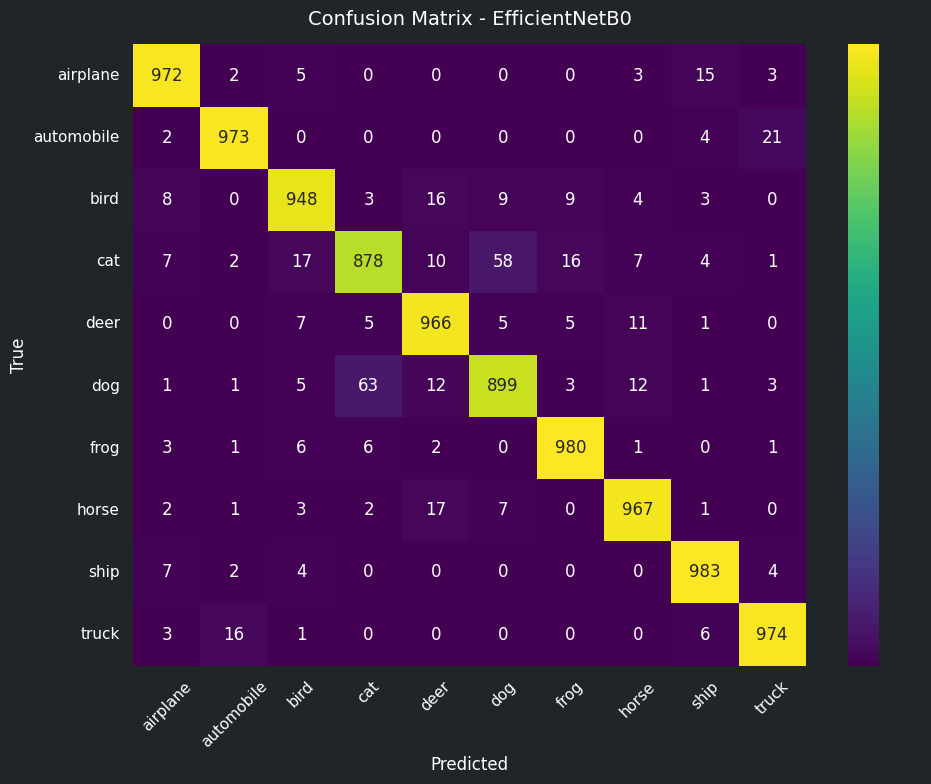

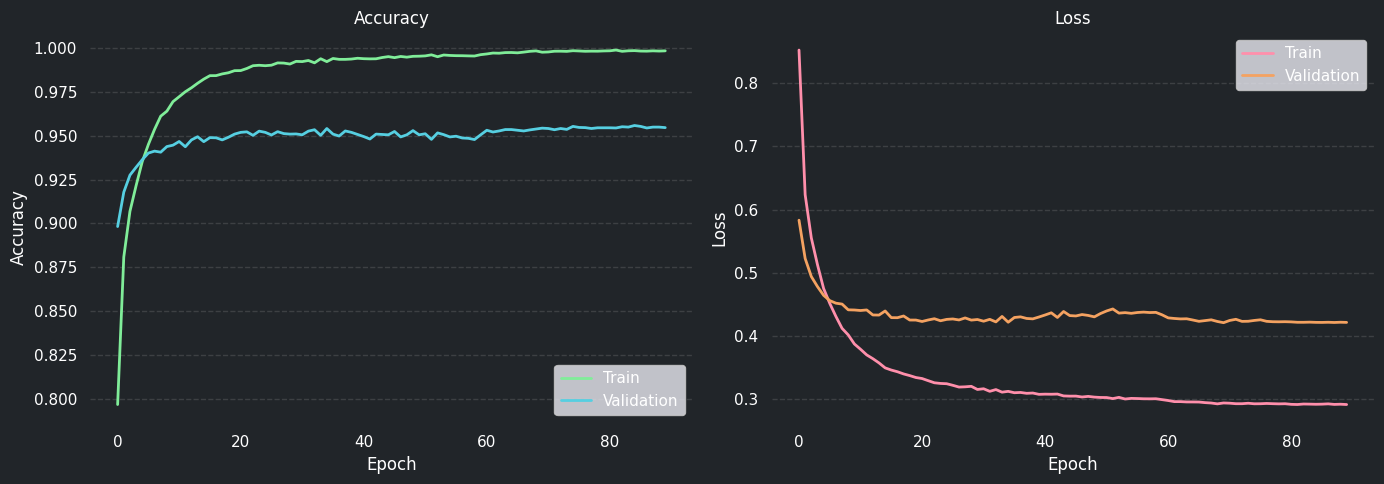

Saved curves to: /mnt/c/Users/User/Documents/Bootcamp AI and Data Science/Linux/DataScience_ironhack/Week6/project/cifar10_project/reports/efficientnet_curves.png


In [10]:
# Detailed metrics, confusion matrix and learning curves via utils
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
y_true, y_pred = predict_and_resolve_labels(model=model, data=test_ds, labels=y_test, verbose=0)

print("Classification Report (Transfer Learning):")
print(build_classification_report(y_true, y_pred, target_names=class_names))

cm = compute_confusion_matrix(y_true, y_pred)
plot_confusion_matrix_notebook01(
    confusion=cm,
    class_names=class_names,
    title='Confusion Matrix - EfficientNetB0',
    save_path=os.path.join(REPORTS_DIR, 'efficientnet_confusion.png'),
)

history_for_plot = history_stage2 if 'history_stage2' in globals() else history_stage1
plot_training_curves_notebook01(
    history=history_for_plot,
    save_path=os.path.join(REPORTS_DIR, 'efficientnet_curves.png'),
)
print("Saved curves to:", os.path.join(REPORTS_DIR, 'efficientnet_curves.png'))

In [2]:
# load keras model saved in h5 format
import tensorflow as tf
from tensorflow.keras.models import load_model

model = load_model('../models/vgg_bn_best_85.h5')

2026-02-19 13:38:30.229222: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-19 13:38:30.491747: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-19 13:38:31.311686: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2026-02-19 13:38:33.815961: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-19 13:38:33.932463: 

In [ ]:
# save model in keras format
model.save('../models/vgg_bn_best_85.keras')